In [3]:
import os
import json
import pickle
import numpy as np
import glob
import random 
import itertools
import arrow
import datetime
from datetime import timezone

from collections import defaultdict, Counter

import pandas as pd
import matplotlib.pyplot as plt
from platform import python_version

from scipy.stats import norm
from scipy.optimize import leastsq
import seaborn as sns

print(python_version())

import sys
sys.path.append("..")

3.7.3


In [4]:
#!pip install arrow

In [5]:
#!pip install fasttext

In [6]:
#!pip install seaborn

In [7]:
from source.utils_npa import get_dpg_data_processed

ModuleNotFoundError: No module named 'source'

In [8]:
data_set = "100kunfilt"

sample_methods = ['n_rnd_users', 'most_common']

data_name = data_set + "_time_split_" + sample_methods[0]

data_path = "../../Data/DPG_nov19/" + data_name + '/'
news_file = data_path + 'news_data.pkl'
user_file = data_path + 'user_data.pkl'

In [9]:
os.listdir(data_path)

['user_data.pkl', 'news_data.pkl', 'logging_dates.json']

In [10]:
os.listdir("../evaluation/")

['.ipynb_checkpoints',
 'plotting.py',
 '__init__.py',
 'data_analysis_dpg.ipynb',
 'get_logs.py']

In [11]:
eval_dir = "../evaluation/" + data_name + '/'
os.makedirs(eval_dir, exist_ok=True)

In [12]:
## load data
with open(news_file, 'rb') as fin:
    news_data = pickle.load(fin)
    
with open(user_file, "rb") as fin:
    user_data = pickle.load(fin)

log_file = "/".join(user_file.split("/")[:-1]) + '/logging_dates.json'
with open(log_file, 'r') as fin:
    logging_dates = json.load(fin)

# determine start of the test interval in UNIX time
if "threshold" in logging_dates.keys():
    start_test_interval = logging_dates['threshold']

In [13]:
#next(iter(news_data['all'].items()))

In [14]:
news_df = pd.DataFrame.from_dict(news_data['all'], orient='index')
news_df = news_df.drop(['author', 'snippet'], axis=1)
news_df.head()

,text,pub_date,first_pub_date,n_words
00016a9,#MeToo-posterroofdier Harvey Weinstein moet wé...,2019-06-19,NaN,547
0001b88,Moeder van Maryori over drama Dordrecht: 'Zij ...,2019-09-16,1.568592e+09,1158
0001c8c,Politie grijpt in bij illegale houseparty in B...,2019-11-24,1.574554e+09,336
000254a,Vrijgelaten moordenares die nog drie maanden t...,2019-11-26,1.574726e+09,260
00036be,Jeugdidool Tsitsipas is een potentiële nummer ...,2019-11-17,1.573949e+09,827


In [15]:
news_train = pd.DataFrame.from_dict(news_data['train'])
news_test = pd.DataFrame.from_dict(news_data['test'])

In [16]:
next(iter(user_data.items()))

('0051f142-a28d-44c2-884d-592c608fa4b1',
 {'articles_read': [('4702e42', 1572615572),
   ('725f0fa', 1572617273),
   ('10b5379', 1572617383),
   ('1d8c0ec', 1572644714),
   ('b258a3e', 1572697066),
   ('753b6b0', 1572795651),
   ('aa8e930', 1572795678),
   ('38291d1', 1572795697),
   ('8d29e14', 1572801924),
   ('5832b8e', 1572801972),
   ('5a74754', 1572802129),
   ('2211429', 1572802248),
   ('7607963', 1572887337),
   ('b3fa551', 1573077314),
   ('310b580', 1573077413),
   ('17cb338', 1573406413),
   ('ae2eba5', 1573406594),
   ('cf64dfa', 1573574573),
   ('6a1b4bb', 1573626291),
   ('e746c33', 1573626468),
   ('f37a51b', 1573713539),
   ('1da6d10', 1573713567),
   ('596b6c2', 1573713595),
   ('b9e6b5b', 1573768897),
   ('d637736', 1573895889),
   ('827ff55', 1573895936),
   ('54ce32c', 1574015762),
   ('5b59fca', 1574015805),
   ('72c449e', 1574015906),
   ('3879fc0', 1574112172),
   ('f986f71', 1574112229),
   ('0580cf2', 1574112322),
   ('db01f0b', 1574112345),
   ('08656d0', 157

In [17]:
user_df = pd.DataFrame.from_dict(user_data, orient='index')
user_df = user_df.drop(['opened_pushes', 'articles_pushed'], axis=1)
user_df.head()

,articles_read,articles_train,articles_test,n_arts_read
000016a9-6665-442b-87f1-662efa7d1b13,"[(f7db535, 1573973552), (1128216, 1574049451),...","[[2ee393d, 1574224464], [64b8b01, 1574397271],...","[[3af2b58, 1575150291], [5c76ef6, 1575150176],...",43
000028fd-5f33-4f22-af7a-360bea33b316,"[(c52a04a, 1572689830), (695145d, 1572689853),...","[[e28bf81, 1573856472], [3e9a656, 1573856531],...","[[184d3d2, 1574666920], [f9bb772, 1574698585],...",44
00005076-becc-4fb6-ae62-cdfa25a241d3,"[(7a5aee3, 1572876220), (e50f89f, 1572945375),...","[[9c92a44, 1574434558], [f54fc33, 1574434512],...",[],8
000058af-a1d9-4ba0-ade0-608197fa3656,"[(4b42f8c, 1572641016), (83f248a, 1572641019),...","[[7d274ca, 1573408336], [6d3ecdc, 1573389816],...","[[d26340b, 1574662983], [39484d0, 1574662931],...",71
0000c650-76db-4bd4-a36a-60bea6e87ad8,"[(6cb4bb2, 1572888139), (e648776, 1572961348),...","[[6cb4bb2, 1572888139], [aebc92c, 1574056156],...",[],15


In [18]:
len(user_df)

100000

## Data Sparsity

How many articles in our subset of all articles are actually read? How many of those during the train and test interval?

In [19]:
n_total_arts = len(news_data['all'])
n_total_read = len(news_data['train'].union(news_data['test']))

data_info = []
data_info.append("Articles in {} item subset: {}".format(data_set, n_total_arts))
data_info.append("Users in {} subset: {}".format(data_set, len(user_data)))
data_info.append("Proportion of read articles: {:.1f}% ({}/{})".format(n_total_read/n_total_arts*100, n_total_read, n_total_arts))
data_info.append("Read Articles \t Train: {} \t Test: {}".format(len(news_data['train']), len(news_data['test'])))

    
with open(eval_dir + "data_info.txt", 'w') as fout:
    for line in data_info: 
        fout.write(line)
        fout.write("\n")
        print(line)

Articles in 100kunfilt item subset: 80884
Users in 100kunfilt subset: 100000
Proportion of read articles: 100.0% (80884/80884)
Read Articles 	 Train: 65844 	 Test: 23983


In [20]:
sns.set()

## Data Overlap

In [77]:
intersec = len(news_data['train'].intersection(news_data['test']))
print("Article overlap between train & test: {} articles".format(intersec))
print("{}/{} articles in test set are present in train".format(intersec, len(news_data['test'])))
print("{:.3f}%".format(intersec/len(news_data['test'])*10))

Article overlap between train & test: 8943 articles
8943/23983 articles in test set are present in train
3.729%


## Number of Articles read per User

Text(0, 0.5, 'Proportion of articles')

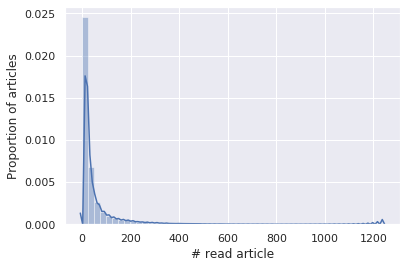

In [78]:
sns.distplot(user_df['n_arts_read'])
plt.xlabel("# read article")
plt.ylabel("Proportion of articles")

(array([0.02842535, 0.01045348, 0.00407957, 0.00237269, 0.00144835,
        0.00112584, 0.0008753 , 0.00067646, 0.00056612, 0.00048189]),
 array([  1. ,  20.8,  40.6,  60.4,  80.2, 100. , 119.8, 139.6, 159.4,
        179.2, 199. ]),
 <a list of 10 Patch objects>)

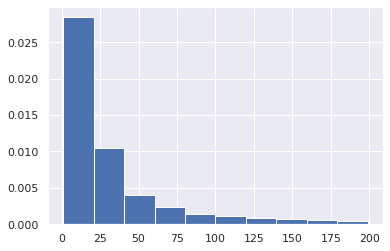

In [79]:
data = user_df[user_df['n_arts_read'] < 200]['n_arts_read']

plt.hist(data, density=True)

In [82]:
def hist_with_mean(data, bins=range(4,150,10), density=True, cumulative=False, cum_thresh=None, max_limit=None, incl_title=False):
    n, bins, patches = plt.hist(data, bins=bins, density=density, cumulative=cumulative)
    plt.axvline(data.mean(), color='orange', linestyle='--', label='mean')
    plt.axvline(data.median(), color='g', linestyle='--', label='median')
    if cumulative and cum_thresh is not None:
        plt.axhline(cum_thresh, color='r', linestyle='-', alpha=0.7)

    plt.xlabel('# reads per user')
    plt.ylabel('Proportion')
    
    if incl_title:
        if max_limit:
            plt.title('Distribution of total # monthly reads per user on {} set (max limit={})'.format(data_set, max_limit))
        else:
            plt.title('Distribution of total # monthly reads per user on {} set (no max limit)'.format(data_set))

    plt.legend()

    print("Mean: %.1f" % data.mean())
    print("Median: %.f" % data.median())
    print("Max: %.f" % data.max())
    print("Std: %.1f" % data.std())
    if cum_thresh is not None:
        print("Cumulative threshold: {} (red horizontal line)".format(cum_thresh))
    return n, bins, patches

Mean: 49.1
Median: 19
Max: 1238
Std: 85.9


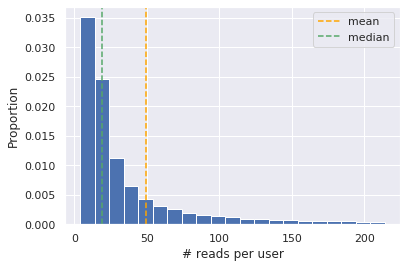

In [83]:
hist_with_mean(user_df['n_arts_read'], bins=range(4,220,10), cumulative=False)
# fname, dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)
fname=eval_dir + data_set + "_n_reads_user_hist_all.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

Mean: 49.1
Median: 19
Max: 1238
Std: 85.9
Cumulative threshold: 0.95 (red horizontal line)


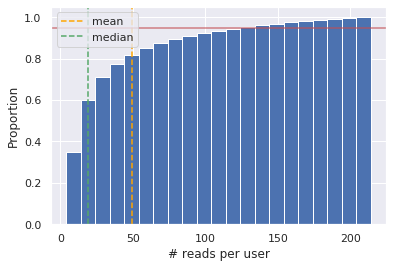

In [84]:
cum_thresh = 0.95
n, bins, patches = hist_with_mean(user_df['n_arts_read'], bins=range(4,220,10), cumulative=True, cum_thresh=cum_thresh)
fname=eval_dir + data_set + "_n_reads_user_cum_hist.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

In [85]:
thresh = 0.9
total = 0
for i, prob in enumerate(n):
    if prob > thresh:
        print(i)
        print(bins[i])
        break

8
84


Cutting off at max of 400 reads, we capture 98.7% of the readership
Mean: 42.3
Median: 18
Max: 400
Std: 60.6


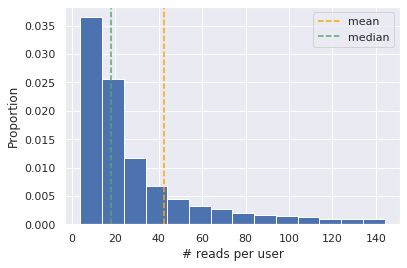

In [86]:
n_max=400

print("Cutting off at max of {} reads, we capture {:.1f}% of the readership".format(n_max, 
                                              len(user_df[user_df['n_arts_read'] < n_max+1])/ len(user_df)*100))


hist_with_mean(user_df[user_df['n_arts_read'] < n_max+1]['n_arts_read'], cumulative=False, max_limit=n_max)
# fname, dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)
fname=eval_dir + data_set + "_n_reads_user_hist_"+str(n_max)+".png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

Cutting off at min of 10 reads, we capture 84.3% of the readership
Mean: 57.0
Median: 23
Max: 1238
Std: 91.4


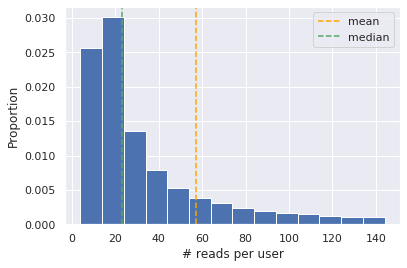

In [87]:
n_min=10

print("Cutting off at min of {} reads, we capture {:.1f}% of the readership".format(n_min, 
                                              len(user_df[user_df['n_arts_read'] >= n_min])/ len(user_df)*100))


hist_with_mean(user_df[user_df['n_arts_read'] >= n_min]['n_arts_read'], cumulative=False, max_limit=n_max)
# fname, dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)
fname=eval_dir + data_set + "_n_reads_user_hist_min"+str(n_min)+".png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

Cutting off at max of 300 reads, we capture 97.5% of the readership (from this subsample)
Mean: 38.6
Median: 18
Max: 300
Std: 50.6


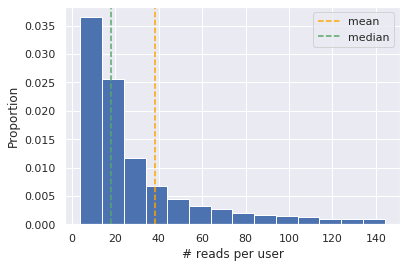

In [88]:
n_max=300

print("Cutting off at max of {} reads, we capture {:.1f}% of the readership (from this subsample)".format(n_max, 
                                              len(user_df[user_df['n_arts_read'] < n_max+1])/ len(user_df)*100))

hist_with_mean(user_df[user_df['n_arts_read'] < n_max+1]['n_arts_read'], cumulative=False, max_limit=n_max)
# fname, dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)
fname=eval_dir + data_set + "_n_reads_user_hist_"+str(n_max)+".png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

Mean: 38.6
Median: 18
Max: 300
Std: 50.6
Cumulative threshold: 0.9 (red horizontal line)


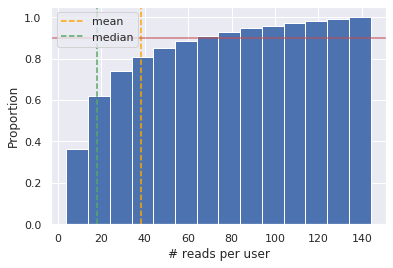

In [89]:
n_max=300
hist_with_mean(user_df[user_df['n_arts_read'] < n_max+1]['n_arts_read'], cumulative=True, cum_thresh=0.9)
fname=eval_dir + data_set + "_n_reads_user_cum_hist_"+str(n_max)+".png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

With min 10 and max 400 reads, we capture 83.0% of the readership
Mean: 49.1
Median: 23
Max: 400
Std: 63.9
Cumulative threshold: 0.95 (red horizontal line)


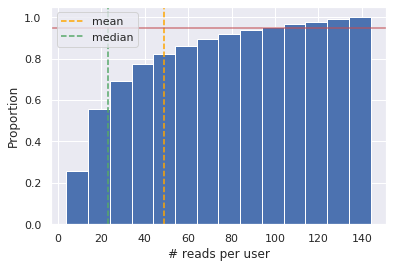

In [90]:
n_max=400
n_min=10
rel_users = user_df[user_df['n_arts_read'] >= n_min]
rel_users = rel_users[rel_users['n_arts_read'] <= n_max]

print("With min {} and max {} reads, we capture {:.1f}% of the readership".format(n_min, n_max, 
                                              len(rel_users)/ len(user_df)*100))


hist_with_mean(rel_users['n_arts_read'], cumulative=True, max_limit=n_max, cum_thresh=0.95)
# fname, dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)
fname=eval_dir + data_set + "_n_reads_user_hist_max"+str(n_max)+"_min"+str(n_min)+".png"
plt.savefig(fname, dpi=400, bbox_inches='tight')



In [91]:
len(user_df[user_df['n_arts_read'] <= 20])/len(user_df)

0.53324

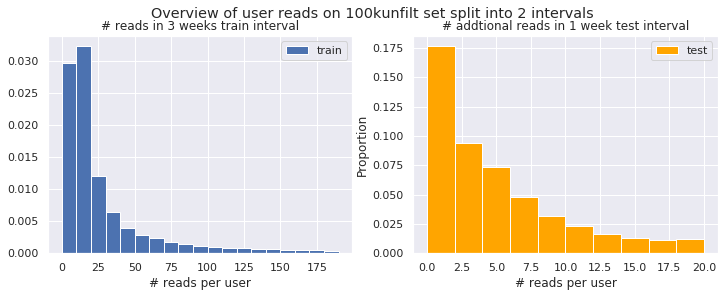

In [92]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(12,4))

dense=True

ax1.hist(user_df['articles_train'].apply(len), bins=range(0,200,10), density=dense, label='train')
ax1.title.set_text("# reads in 3 weeks train interval")
plt.ylabel('Proportion')

ax2.hist(user_df['articles_test'].apply(len), bins=range(0,22,2), density=dense, color='orange', label='test')
ax2.title.set_text("# addtional reads in 1 week test interval")

for ax in (ax1, ax2):
    ax.legend()
    ax.set_xlabel('# reads per user')

plt.suptitle('Overview of user reads on {} set split into 2 intervals'.format(data_set))
plt.show()

## Words per Article

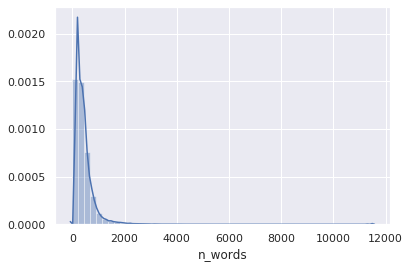

In [93]:
sns.distplot(news_df['n_words'])

Max: 11500
Min: 1
Mean: 409
Median: 322
Std: 368.9


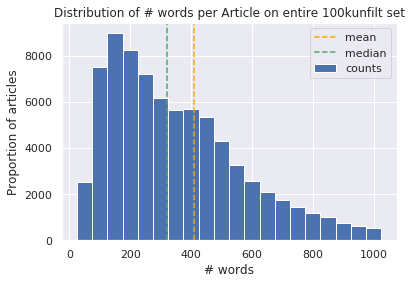

In [94]:
#
bins=range(25,1050,50)
plt.hist(news_df['n_words'], bins=bins, density=False, label='counts')


(mu, sigma) = norm.fit(news_df['n_words'])
y = norm.pdf(bins, mu, sigma)
plt.axvline(mu, color='orange', linestyle='--', label='mean')
plt.axvline(news_df['n_words'].median(), color='g', linestyle='--', label='median')
#plt.plot(bins, y, 'r--')

plt.xlabel('# words')
plt.ylabel('Proportion of articles')
plt.title('Distribution of # words per Article on entire {} set'.format(data_set))

plt.legend()

print("Max: %.f" % news_df['n_words'].max())
print("Min: %.f" % news_df['n_words'].min())
print("Mean: %.f" % news_df['n_words'].mean())
print("Median: %.f" % news_df['n_words'].median())
print("Std: %.1f" % news_df['n_words'].std())

fname=eval_dir + data_set + "_n_words_all_nov19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

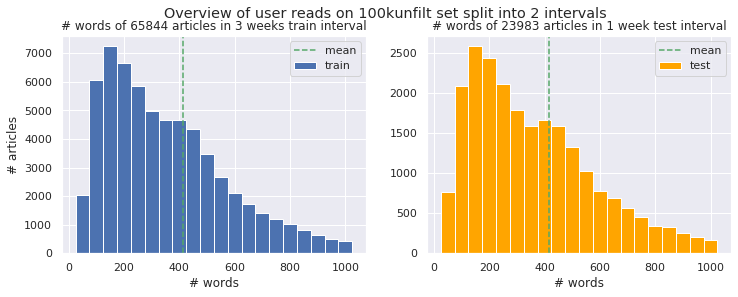

In [95]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(12,4))

ax1.hist(news_df.loc[news_data['train']]['n_words'], bins=bins, density=False, label='train')
ax1.axvline(news_df.loc[news_data['train']]['n_words'].mean(), color='g', linestyle='--', label='mean')
ax1.title.set_text("# words of {} articles in 3 weeks train interval".format(len(news_df.loc[news_data['train']])))
ax1.set_ylabel('# articles')

ax2.hist(news_df.loc[news_data['test']]['n_words'], bins=bins, density=False, color='orange', label='test')
ax2.axvline(news_df.loc[news_data['test']]['n_words'].mean(), color='g', linestyle='--', label='mean')
ax2.title.set_text("# words of {} articles in 1 week test interval".format(len(news_df.loc[news_data['test']])))

for ax in (ax1, ax2):
    ax.legend()
    ax.set_xlabel('# words')

plt.suptitle('Overview of user reads on {} set split into 2 intervals'.format(data_set))
plt.show()

fname=eval_dir + data_set + "_n_words_traintest_nov19.png"
fig.savefig(fname, dpi=400)

In [96]:
'''
create buckets for different time intervals 
iterate through each 'article_read' for all users
assign article to bucket depending on 'time_stamp'
plot buckets as histogram
'''

"\ncreate buckets for different time intervals \niterate through each 'article_read' for all users\nassign article to bucket depending on 'time_stamp'\nplot buckets as histogram\n"

In [97]:
import datetime
from datetime import timezone, timedelta

In [98]:
datetime.datetime(2019, 12, 1, 23, 59, 59).strftime('%s')

'1575241199'

In [99]:
t1 = datetime.datetime(2019, 12, 1, 23, 59, 59)

In [100]:
t2 = datetime.datetime(2019, 12, 24, 23, 59, 59)

In [101]:
delta = (t1 - t2)
delta

datetime.timedelta(days=-23)

In [102]:
delta.total_seconds() / (60*60*24)

-23.0

In [103]:
datetime.datetime.utcfromtimestamp(int('1577228399')).strftime('%Y-%m-%d %H:%M:%S')

'2019-12-24 22:59:59'

In [104]:
datetime.datetime.fromtimestamp(int('1577228399'))

datetime.datetime(2019, 12, 24, 23, 59, 59)

In [105]:
t2 < t1

False

In [106]:
def counts_per_bucket(user_data, buckets=range(1,32), scale='day', normalise=False):
    reads_per_bucket = defaultdict(int)
    
    #smallest_t=None
    
    for u_id in user_data:
        art_ids, time_stamps = zip(*user_data[u_id]['articles_read'])
        for time_stamp in time_stamps:
            for bucket in buckets:
                t = datetime.datetime.fromtimestamp(time_stamp)
                if 'hour' == scale:
                    if t.hour==bucket and bucket != 0:
                        reads_per_bucket[bucket] += 1
                        break
                    elif bucket==0 and t.hour==buckets[-1]:
                        reads_per_bucket[bucket] += 1
                        break
                    
                elif 'day'==scale and t.day == bucket:
                    reads_per_bucket[bucket] += 1
                    break
                
                elif 'week'==scale and t.day/7 < bucket:
                    reads_per_bucket[bucket] += 1
                    break
                    
    #print("Earliest time: {}, {}".format(datetime.datetime.fromtimestamp(smallest_dt).strftime('%A'), 
    #                                     datetime.datetime.fromtimestamp(smallest_dt)))
    x, y = zip(*sorted(reads_per_bucket.items()))
    
    if normalise:
        y = [val/len(user_data) for val in y]
    
    return x, y

In [107]:
def counts_per_interval_buckets(user_data, intervals : dict, plot=True, in_plot1=["morning", "noon", "afternoon"], 
                               ylim=[0,1000], sharey=False):
    out_dict = {key: defaultdict(int) for key in intervals.keys()}

    for u_id in user_data:
        art_ids, time_stamps = zip(*user_data[u_id]['articles_read'])
        for time_stamp in time_stamps:
            hour = datetime.datetime.fromtimestamp(time_stamp).hour
            minute = datetime.datetime.fromtimestamp(time_stamp).minute
            day = datetime.datetime.fromtimestamp(time_stamp).day

            for key, interval in daytime_intervals.items():
                if interval[0] <= hour <= interval[1]:
                    out_dict[key][day] += 1
                    break
                elif "night" == key:
                    if interval[0] <= hour or hour <= interval[1]:
                        out_dict[key][day] += 1
                        break
    if plot:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=sharey, figsize=(12,4))

        for daytime, reads_per_day in out_dict.items():
            x, y = zip(*sorted(reads_per_day.items()))
            if daytime in in_plot1:
                ax1.plot(x, y, label=daytime)
            else:
                ax2.plot(x, y, label=daytime)
        
        plt.xlabel("Day")
        ax1.set_ylabel("# articles read")
        ax1.legend()
        ax2.legend()
        if ylim is not None:
            plt.ylim(ylim)

    return out_dict

## Reading behaviour over Time

In [108]:
a = arrow.get('2019-11-15')
a.format('dddd')

'Friday'

Users: 100000


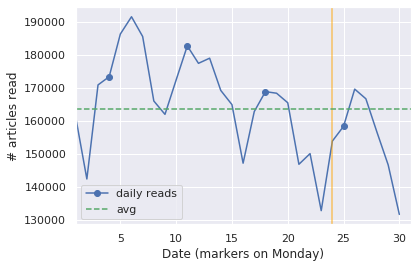

In [114]:
x, y = counts_per_bucket(user_data, buckets=range(1,32), scale='day')


plt.plot(x, y, label="daily reads", marker='o',markevery=list(range(3,len(x),7)))
plt.axvline(24, color='orange', linestyle='-', alpha=0.6)
plt.axhline(np.mean(y), color='g', linestyle='--', label="avg")
plt.xlabel("Date (markers on Monday)")
plt.ylabel("# articles read")
#plt.title("Read articles for users in {} set over 1 month (Nov19)".format(data_set))
#plt.ylim([0, 2000])
plt.xlim([1,31])
plt.legend()
print("Users: {}".format(len(user_data)))

fname=eval_dir + data_set + "_n_reads_daily_nov19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

Interaction ratio of 1 means that each user reads 1 article per day


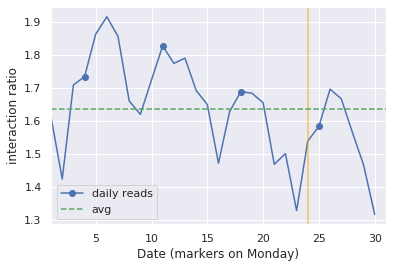

In [115]:
x, y = counts_per_bucket(user_data, buckets=range(1,32), scale='day', normalise=True)

plt.plot(x, y, label="daily reads", marker='o',markevery=list(range(3,len(x),7)))
plt.axvline(24, color='orange', linestyle='-', alpha=0.6)
plt.axhline(np.mean(y), color='g', linestyle='--', label="avg")
plt.xlabel("Date (markers on Monday)")
plt.ylabel("interaction ratio")
#plt.title("Interaction ratio for users in {} set over 1 month (normalised)".format(data_set))
#plt.ylim([0, 2000])
plt.xlim([1,31])
plt.legend()
print("Interaction ratio of 1 means that each user reads 1 article per day")

fname=eval_dir + data_set + "_read_ratio_daily_nov19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

Peak at 8:
Low at 3:


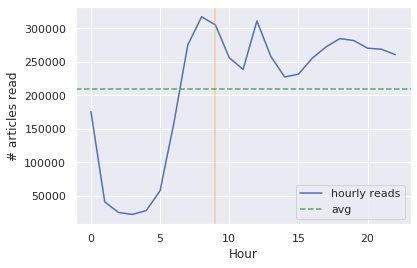

In [116]:
x, y = counts_per_bucket(user_data, buckets=range(0,24), scale='hour')
plt.plot(x, y, label="hourly reads")
plt.axvline(9, color='orange', linestyle='-', alpha=0.4)
plt.axhline(np.mean(y), color='g', linestyle='--', label="avg")
plt.xlabel("Hour")
plt.ylabel("# articles read")
#plt.title("Read articles for users in {} set per hour aggregated for 1 month".format(data_set))
#plt.ylim([0, 2000])

plt.legend()
print("Peak at {}:".format(np.argmax(y)))
print("Low at {}:".format(np.argmin(y)))

fname=eval_dir + data_set + "_n_reads_24h_nov19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

Peak at 8:
Low at 3:


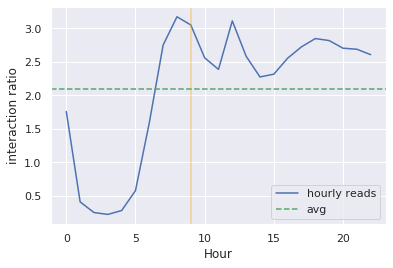

In [113]:
x, y = counts_per_bucket(user_data, buckets=range(0,24), scale='hour', normalise=True)
plt.plot(x, y, label="hourly reads")
plt.axvline(9, color='orange', linestyle='-', alpha=0.4)
plt.axhline(np.mean(y), color='g', linestyle='--', label="avg")
plt.xlabel("Hour")
plt.ylabel("interaction ratio")
#plt.title("Read articles for users in {} set per hour aggregated for 1 month (Nov19)".format(data_set))
#plt.ylim([0, 2000])

plt.legend()
print("Peak at {}:".format(np.argmax(y)))
print("Low at {}:".format(np.argmin(y)))

fname=eval_dir + data_set + "_read_ratio_24h_nov19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

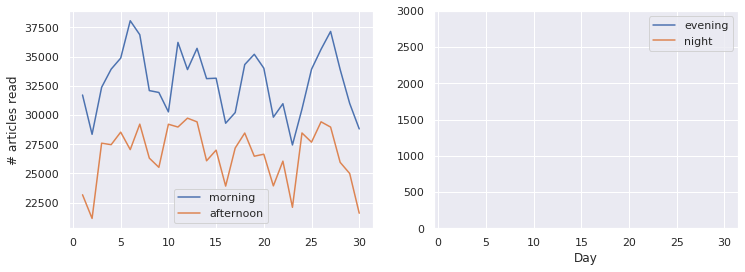

In [292]:
daytime_intervals = {
    "morning": (6,12),
    "afternoon": (12, 18),
    "evening": (18, 23),
    "night": (23,6),
}

out_dict = counts_per_interval_buckets(user_data, daytime_intervals, ylim=[0,3000])

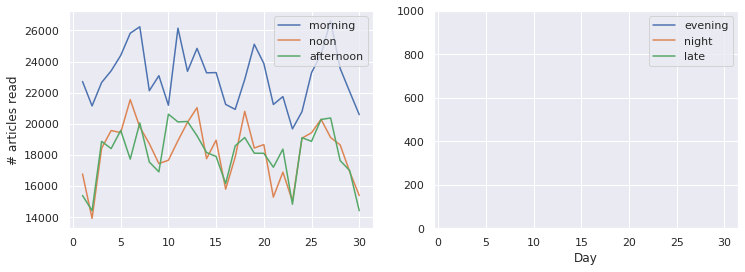

In [293]:
daytime_intervals = {
    "morning": (6,10),
    "noon": (10, 14),
    "afternoon": (14, 18),
    "evening": (18, 22),
    "night": (22,2),
    "late": (2, 6)
}

out_dict = counts_per_interval_buckets(user_data, daytime_intervals)

In [294]:
t1 = datetime.datetime.fromtimestamp(1575806402)
print(datetime.datetime.fromtimestamp(1575806402).strftime('%Y-%m-%d %H:%M:%S'))
print("Day {}, Hour {}, Minute {}".format(t1.day, t1.hour, t1.minute))

t2 = datetime.datetime(2019,12,1,0,10,50)
print("Day {}, Hour {}, Minute {}".format(t2.day, t2.hour, t2.minute))

2019-12-08 13:00:02
Day 8, Hour 13, Minute 0
Day 1, Hour 0, Minute 10


In [295]:
t2 - t1

datetime.timedelta(days=-8, seconds=40248)

In [296]:
t1 - t2

datetime.timedelta(days=7, seconds=46152)

In [297]:
(t1-t2).total_seconds()

650952.0

In [298]:
def timedeltas_in_buckets(user_data, resolution="minutes"):
    delta_dist = []
    for u_id in user_data:
        arts = user_data[u_id]['articles_read']
        _, time_stamps = zip(*arts)
        for i, time_stamp in enumerate(sorted(time_stamps)):
            if i != 0: 
                delta = datetime.datetime.fromtimestamp(time_stamp) - prev_stamp
                
                if delta.total_seconds() < 0:
                    print(time_stamps)
                    break
                
                if "minutes" == resolution:
                    delta = delta.total_seconds()/60
                elif "seconds" == resolution:
                    delta = delta.total_seconds()
                elif "hours" == resolution:
                    delta = delta.total_seconds()/ (60*60)
                else:
                    raise NotImplemented()
                
                delta_dist.append(delta)
                
            prev_stamp = datetime.datetime.fromtimestamp(time_stamp)
            
    return delta_dist

In [299]:
deltas = timedeltas_in_buckets(user_data, resolution="minutes")

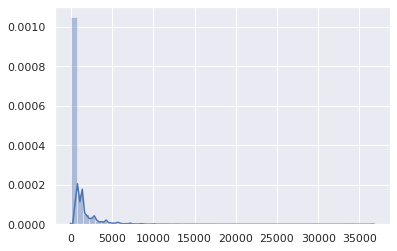

In [300]:
sns.distplot(deltas)

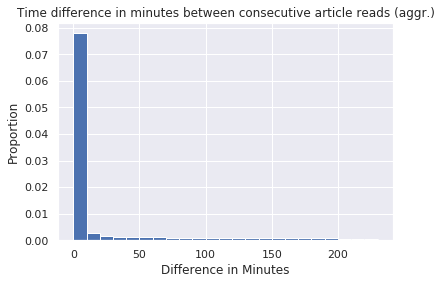

In [301]:
plt.hist(deltas, bins=range(0,240,10), density=True)
plt.xlabel("Difference in Minutes")
plt.ylabel("Proportion")
plt.title("Time difference in minutes between consecutive article reads (aggr.)")

fname=eval_dir + data_set + "_timedif_reads_240min_nov19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

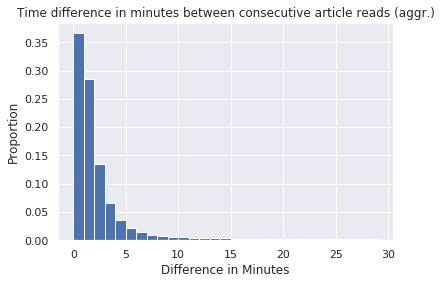

In [302]:
#deltas_filt = [delta for delta in deltas if delta<50]
plt.hist(deltas, bins=range(0,30,1), density=True)
plt.xlabel("Difference in Minutes")
plt.ylabel("Proportion")
plt.title("Time difference in minutes between consecutive article reads (aggr.)")

fname=eval_dir + data_set + "_timedif_reads_30min_nov19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

In [303]:
# first & last read - just one session? multiple reads per day / week 
# given history of N articles, how many session are this? -> cluster by time
# towards session awareness? build test set with specific users to evaluate the model capacity

In [304]:
# current time for when to make a recommendation
# potential overfit on recency?


In [305]:
'''
sample N users with a hist_length > l
compute time_delta between consecutive reads
plot procession of those delta 
x: position in history
y: time delta

expect: session transitions show high time delta, i.e. large time difference between two reads

'''

'\nsample N users with a hist_length > l\ncompute time_delta between consecutive reads\nplot procession of those delta \nx: position in history\ny: time delta\n\nexpect: session transitions show high time delta, i.e. large time difference between two reads\n\n'

In [306]:
def timedeltas_per_user(user_data, resolution="minutes"):
    delta_dist = defaultdict(list)
    
    for u_id in user_data:
        arts = user_data[u_id]['articles_read']
        _, time_stamps = zip(*arts)
        for i, time_stamp in enumerate(sorted(time_stamps)):
            if i != 0: 
                delta = datetime.datetime.fromtimestamp(time_stamp) - prev_stamp
                
                if delta.total_seconds() < 0:
                    print(time_stamps)
                    break
                
                if "minutes" == resolution:
                    delta = delta.total_seconds()/60
                elif "seconds" == resolution:
                    delta = delta.total_seconds()
                elif "hours" == resolution:
                    delta = delta.total_seconds()/ (60*60)
                else:
                    raise NotImplemented()
                
                delta_dist[u_id].append(delta)
                
            prev_stamp = datetime.datetime.fromtimestamp(time_stamp)
            
    return delta_dist

In [307]:
N = 10
min_hist_len = 40

subset = {}
while len(subset) < N:
    u_id = random.choice(list(user_data.keys()))
    if u_id not in subset and user_data[u_id]['n_arts_read'] >= min_hist_len:
        subset[u_id] = user_data[u_id]

#subset = {u_id: user_data[u_id] for u_id in u_sample}

In [308]:
60*60*2

7200

In [309]:
deltas = timedeltas_per_user(subset, resolution="minutes")

Text(0, 0.5, 'Time delta [min]')

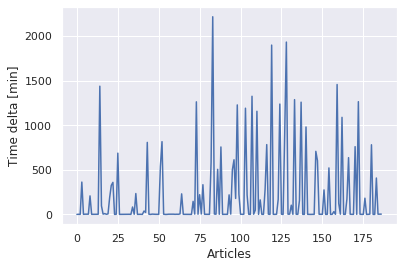

In [310]:
plt.plot(next(iter(deltas.values())))
plt.xlabel("Articles")
plt.ylabel("Time delta [min]")

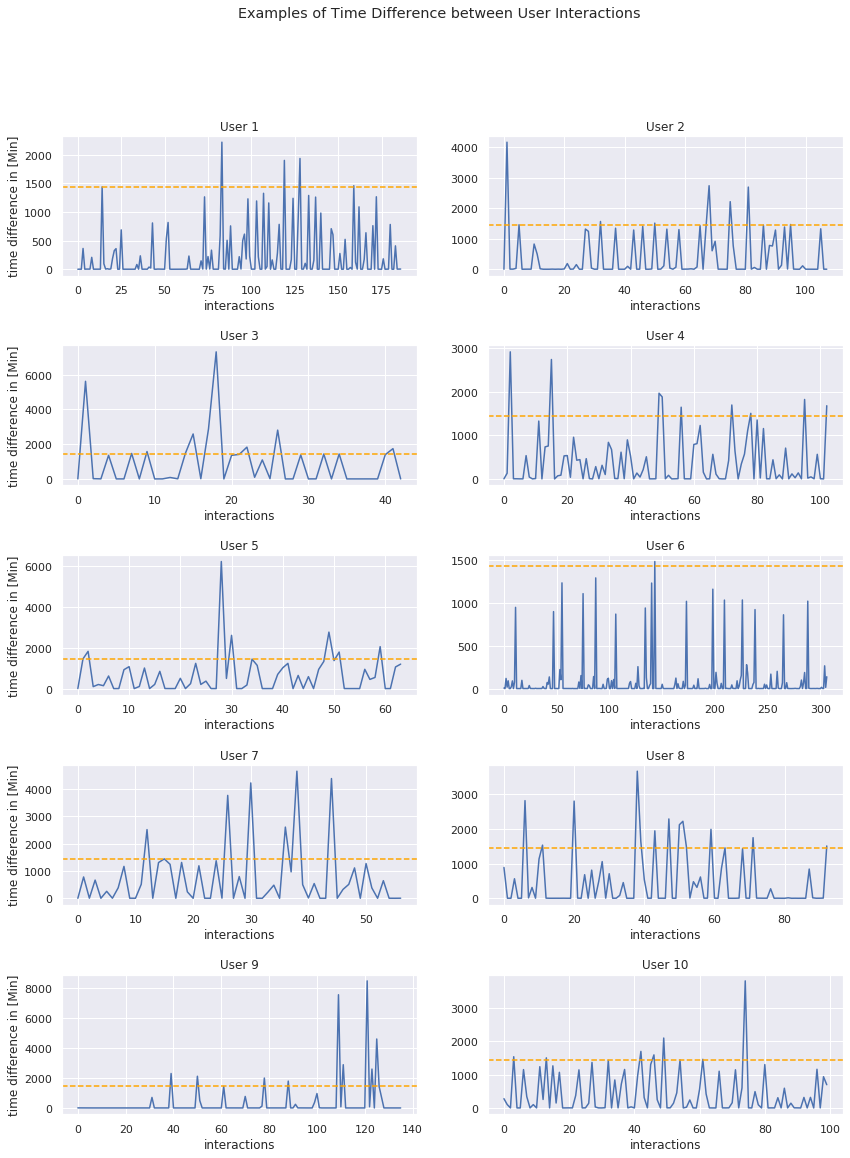

<Figure size 432x288 with 0 Axes>

In [311]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(14,18))
#keep_u = [0,1,3,5,6,9]
axs = list(itertools.chain(*axs))
#assert len(axs) == len(deltas)
for i, u_id in enumerate(deltas):
    
    axs[i].plot(deltas[u_id], label=u_id)
    axs[i].axhline(60*24, color='orange', linestyle='--', label='24h')

    axs[i].set_xlabel("interactions")
    if i % 2 == 0:
        axs[i].set_ylabel("time difference in [Min]")
    axs[i].title.set_text("User {}".format(i+1))
    #axs[i].set_yscale('logit')
    
plt.suptitle('Examples of Time Difference between User Interactions')
plt.subplots_adjust(hspace = 0.5)
plt.show()

fname=eval_dir + data_set + "_timedif_reads_n10_nov19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

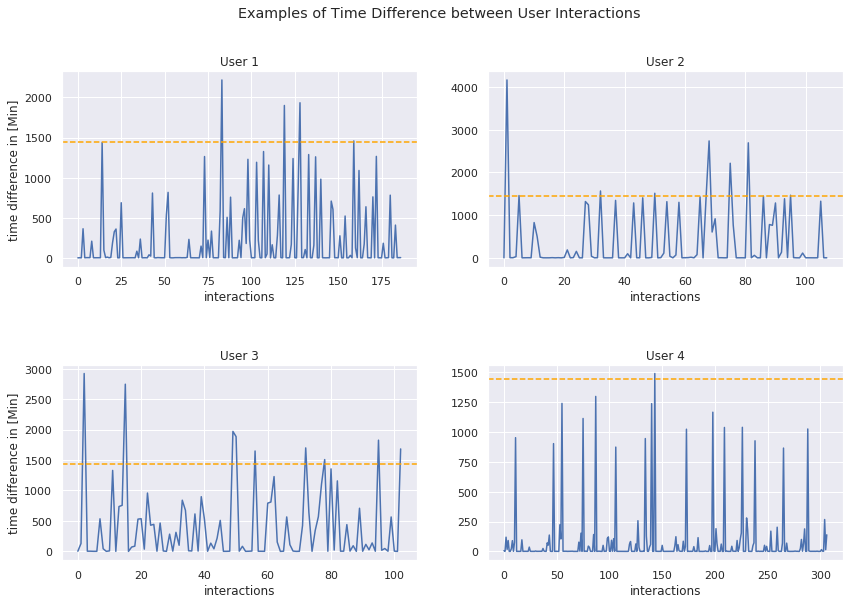

<Figure size 432x288 with 0 Axes>

In [312]:
keep_u = [0,1,3,5]
deltas = {u_id: deltas[u_id] for i, u_id in enumerate(deltas) if i in keep_u}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,9))

axs = list(itertools.chain(*axs))
#assert len(axs) == len(deltas)
for i, u_id in enumerate(deltas):
    
    axs[i].plot(deltas[u_id], label=u_id)
    axs[i].axhline(60*24, color='orange', linestyle='--', label='24h')

    axs[i].set_xlabel("interactions")
    if i % 2 == 0:
        axs[i].set_ylabel("time difference in [Min]")
    axs[i].title.set_text("User {}".format(i+1))
    #axs[i].set_yscale('logit')
    
plt.suptitle('Examples of Time Difference between User Interactions')
plt.subplots_adjust(hspace = 0.5)
plt.show()

fname=eval_dir + data_set + "_timedif_reads_n10_nov19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')